In [1]:
import os, json, pickle

import numpy as np
from matplotlib import pyplot as plt

from enterprise import constants as const
from enterprise.pulsar import Pulsar
from enterprise.signals import signal_base
from enterprise.signals import gp_signals
from enterprise.signals import gp_priors
from enterprise.signals import parameter
from enterprise.signals import selections

from enterprise_extensions import blocks

# using `enterprise_extensions`

`enterprise_extensions` provides "recipes" for commonly used functionality in `enterprise`.

Lets build a 3 pulsar PTA that we could use to search for a gravitational wave background. 

## load data

In [2]:
datafiles = {
    "J1600-3053":{"par":"J1600-3053_EPTA_6psr.par", "tim":"J1600-3053_EPTA_6psr.tim"},
    "J2241-5236":{"par":"J2241-5236_PPTA_dr2.par", "tim":"J2241-5236_PPTA_dr2.tim"},
    "J2317+1439":{"par":"J2317+1439_NANOGrav_12y.par", "tim":"J2317+1439_NANOGrav_12y.tim"},
}

datadir = os.path.abspath("data")

In [3]:
# load in each pulsar and append it to a list
psrs = []
for pname, fdict in datafiles.items():
    pfile = os.path.join(datadir, fdict["par"])
    tfile = os.path.join(datadir, fdict["tim"])
    psrs.append(Pulsar(pfile, tfile))

Current filename = J1600-3053_EPTA_6psr.tim
Rel path = /Users/ptbaker/Projects/viper_enterprise/data/epta_tims/EFF.P200.1400.tim
Current filename = J1600-3053_EPTA_6psr.tim
Rel path = /Users/ptbaker/Projects/viper_enterprise/data/epta_tims/EFF.P217.1400.tim
Current filename = J1600-3053_EPTA_6psr.tim
Rel path = /Users/ptbaker/Projects/viper_enterprise/data/epta_tims/EFF.S110.2639.tim
Current filename = J1600-3053_EPTA_6psr.tim
Rel path = /Users/ptbaker/Projects/viper_enterprise/data/epta_tims/JBO.ROACH.1520.tim
[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 
Current filename = J1600-3053_EPTA_6psr.tim
Rel path = /Users/ptbaker/Projects/viper_enterprise/data/epta_tims/LEAP.1396.tim
Current filename = J1600-3053_EPTA_6psr.tim
Rel path = /Users/ptbaker/Projects/viper_enterprise/data/epta_tims/NRT.BON.1400.tim
[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.
Current filename = J1600-3053_EPTA_6psr.tim
Rel path = /Users/ptbaker/P

[preProcess.C:158] Warning: PSR J2241-5236 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[tempo2Util.C:396] Warning: [MISC1] Unknown parameter in par file:  DMX

[tempo2Util.C:396] Warning: [PAR2] Have not set a DM epoch. The period epoch will be used instead. J2317+1439_NANOGrav_12y.par
[observatory.C:271] Warning: Assuming site '3' means 'ao'


(once again, we can safely ignore these `tempo2` warnings)

## determine the PTA `Tspan`
When building a `PTA` using data from multiple pulsars it helps to have a common Fourier basis for all of the pulsars' red noise (and common red noise, like GWB).  The easy way to do this is to use the total time-span of all data to set the Fourier frequencies.

`enterprise.signals.gp_signals.FourierBasisGP` can use an intput `Tspan` to figure out the frequencies, and several functions in `enterprise_extensions` can too.

In [4]:
# calculate the total Tspan
Tspan = np.max([pp.toas.max() - pp.toas.min() for pp in psrs])

In [5]:
Tspan / const.yr

13.99862013884578

## generate an enterprise `PTA` for all three pulsars for a CRN analysis

Each pulsar needs a different noise model.  For CRN analysis it is common to fix the WN parameters based on previous single pulsar noise runs.

To speed up the likelihood calculation we can use the `enterprise.signals.gp_signals.MarginalizingTimingModel`, which breaks the GP coefficient marginalization into two steps.  The linear timing model is analytically marginalized first.  This reduces the size of the matrices that must be inverted at each likelihood evaluation.  Only the Fourier Basis GPs (RN, DM, GWB, ...) contribute.

We're going to use a spatially correlated common red noies model with a powerlaw spectrum as our GWB.

Let's start by building the parts of the model that all pulsars will include:

* timing model
* red noise -- 30 frequency powerlaw -- `enterprise_extensions.blocks.red_noise_block`
* GWB -- 15 frequency powerlaw, Hellings-Downs correlated -- `enterprise_extensions.blocks.common_red_noise_block`
 * $\log_{10} A \rightarrow$ Uniform(-18, -13)
 * $\gamma=13/3$

In [6]:
# make the timing model signal
tm = gp_signals.MarginalizingTimingModel(use_svd=True)

In [7]:
# make the RN signal
rn = blocks.red_noise_block(
    psd="powerlaw", components=30,
    Tspan=Tspan
)

In [8]:
# make the GWB signal
gw = blocks.common_red_noise_block(
    psd="powerlaw", components=15,
    gamma_val=13/3,
    orf="hd",
    Tspan=Tspan
)

Since each pulsar has a unique model, we'll store the three `SignalCollections` as a list.

In [9]:
# empty list to store each pulsar's "signal" model
sigs = []

### generate an enterprise signal model for EPTA's J1600 pulsar

In addition to the timing model, RN, and GWB, we need to include:

* white noise -- fixed EFAC & EQUAD per backend (no ECORR)
* DM variations -- 100 frequency powerlaw DM GP

These are easy to do using `enterprise_extensions.blocks`.

For a GWB analysis it is common to hold the white noise parameters (EFAC/EQUAD/ECORR) fixed to some known value (as determined by a single pulsar analysis.
This reduces the number of parameters in the full PTA model.
`enterprise` accomplishes this by using the `parameter.Constant` class.
`enterprise_extensions.blocks.white_noise_block` has a boolean option to control this behavior.
We'll use `vary=False` for **fixed** WN.

In [10]:
# make the WN signal
wn = blocks.white_noise_block(vary=False, inc_ecorr=False, select="backend")

In [11]:
# make the DM GP signal
dm = blocks.dm_noise_block(gp_kernel="diag", psd="powerlaw", components=100, Tspan=Tspan)

In [12]:
# append J1600's SignalCOllection to the list
sigs.append(tm + wn + rn + dm + gw)

### generate an enterprise signal model for PPTA's J2241 pulsar

In addition to the timing model, RN, and GWB, we need to include:

* white noise -- fixed EFAC & EQUAD per backend (no ECORR)
* DM variations -- 100 frequency powerlaw DM GP
* band noise -- 30 frequency powerlaw in the 20cm band

We can reuse the same `wn` and `dm` signals from before.

To implement band noise we need a `enterprise.signal.selections.Selection`.
A selection function takes the `dict` of TOA flags and flagvals as input. 
It returns a `dict` whose keys are the flagvals to select and mask (array of True/False) telling which TOAs have that flag.

There's a built in `by_band` selection function, but that applies band noise to **all** bands.
We only want to apply this model to TOAs in the 20cm band, so we need a selection function that returns a `dict` with one key and a mask for that flagval.

In [13]:
def band_20cm(flags):
    """function to select TOAs in 20cm band (-B 20CM)"""
    flagval = "20CM"
    return {flagval: flags["B"] == flagval}

by_band_20cm = selections.Selection(band_20cm)

There's no band noise block in `enterprise_extensions` but we can make a Fourier basis GP with the appropriate selection the old fashioned way!

In [14]:
# band noise parameters
BN_logA = parameter.Uniform(-20, -11)
BN_gamma = parameter.Uniform(0, 7)

# band noise powerlaw prior
powlaw = gp_priors.powerlaw(log10_A=BN_logA, gamma=BN_gamma)

# make band noise signal (don't forget the name!)
bn = gp_signals.FourierBasisGP(
    powlaw,
    components=30,
    Tspan=Tspan,
    selection=by_band_20cm,
    name="band_noise"
)

In [15]:
# append J2241's SignalCOllection to the list
sigs.append(tm + wn + rn + bn + dm + gw)

### generate an enterprise signal model for NANOGrav's J2317 pulsar

In addition to the timing model, RN, and GWB, we need to include:

* white noise -- fixed EFAC, EQUAD, **and ECORR** per backend

Remember there is no DM variations model, because DMX is already in the timing model for NANOGrav's 12.5yr data release

In [16]:
# make WN signal (now with ECORR!)
wn_ec = blocks.white_noise_block(vary=False, inc_ecorr=True, select="backend")

In [17]:
# append J2317's SignalCOllection to the list
sigs.append(tm + wn_ec + rn + gw)

## put the three pulsars together into a `PTA` object

We can instantiate a PTA object with a list of three pulsar models.
We simply feed each `Pulsar` to its `SignalCollection`, and then pass the whole list of instantiated models to `signal_base.PTA`.

In [18]:
pta = signal_base.PTA([ss(pp) for ss,pp in zip(sigs, psrs)])

### load noise dictionary

At this point we never actually told `enterprise` what to use for the fixed the WN parameters.
We can use `PTA.set_default_params` to pass in the correct WN values from a `dict`.

First we'll load the dictionary, which is stored as a `.json` file in the `data/` directory

In [19]:
nfile = os.path.join(datadir, "viper_3psr_noise.json")
with open(nfile, "r") as f:
    noisedict = json.load(f)

In [20]:
# set the fixed WN params
pta.set_default_params(noisedict)

### evaluate the log-likelihood!

In [21]:
# generate a random point
x0 = {pp.name:pp.sample() for pp in pta.params}

In [22]:
# calculate logL and logPr
pta.get_lnlikelihood(x0), pta.get_lnprior(x0)

(225348.53184581103, -26.245102719469088)

For the spatially correlated GWB model, the $\varphi$ matrix is no longer diagonal!  We can check the shape of `PTA.get_phiinv` and see that it is stored as a full matrix, not a vector.

In [23]:
# check the shape of phiinv
pta.get_phiinv(x0).shape

(640, 640)

The GP basis design matrix, $\mathbb{T}$, is a list, containing an entry for each pulsar.
Each entry is $N_\mathrm{TOA}\times N_\mathrm{coef}$ for that pulsar.
Because we used the `MarginalizingTimingModel`, the timing model which has no varying parameters already been marginalized.

This leaves J2317 with a 30 component Fourier Basis GP and 60 basis coefficients.
The GWB and RN models share a common basis, so the 15 GWB components don't add any extra.

J1600 has an additional 200 coefficients, from the 100 component DM GP model.
The DM variations are not applied the same way to all TOAs, different radio frequency observations are affected differently.  This means that even though the DM basis uses the same frequencies, it cannot share basis coefficients with the *achromatic* GWB and RN models.

In addition to DM variations J2241 had a 30 component band-noise model, adding in an extra 60 coefficients.
Band noise is achromatic, but it only applies to a subset of the full TOAs.
This model can't share basis coefficients with the other models

In [24]:
# check the shape of each T-matrix
[T.shape for T in pta.get_basis()]

[(3345, 260), (5224, 320), (9835, 60)]

# run a quick MCMC

`enterprise_extensions.sampler.setup_sampler()` returns a `PTMCMCSampler` object.
The MCMC sampler can be tuned to improve performance.
The defaults of `setup_sampler` are often fine, but suboptimal.
One can fine improved acceptance and convergence, but adjusting the inputs to `setup_sampler` or setting up the sampler manually.

In [25]:
from enterprise_extensions.sampler import setup_sampler
from matplotlib import pyplot as plt

Do not have mpi4py package.
Do not have acor package


### Run a short MCMC using this PTA object

Check the output to see what is generated and plot a trace of the log-Posterior

* set the output directory
* specify yourself as the "human" running the job

* remember the sampler takes a `numpy.ndarray` for the starting location, not a `dict`

* set `burn=1000` (the DE buffer)
* set `thin=2` (save every other sample)
* collect `2000` samples (if we thin by 2, we'll need to run for `Niter=4000`!)

In [26]:
# specify the output directory
outdir = "mcmc_test"

In [27]:
# setup the sampler
sampler = setup_sampler(pta, outdir=outdir, human="ptb")

Adding red noise prior draws...

Adding DM GP noise prior draws...

Adding GWB uniform distribution draws...



In [28]:
# generate an initial sample and run the sampler!
p0 = np.hstack(list(x0.values()))

B = 1_000
T = 2
Nsamp = 2_000

N = 2*Nsamp
sampler.sample(
    p0, Niter=N,
    burn=B, thin=T
)

/Users/ptbaker/opt/anaconda3/envs/ent15y/lib/python3.9/site-packages/enterprise/signals/parameter.py:62: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 25.00 percent in 9.173659 s Acceptance rate = 0.357Adding DE jump with weight 20
Finished 75.00 percent in 27.228359 s Acceptance rate = 0.368333
Run Complete


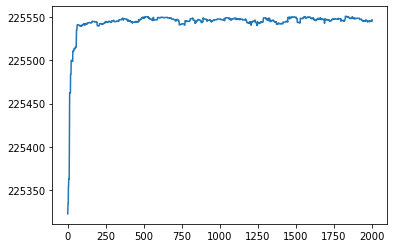

In [29]:
burn = 0  # try setting burn to 200 or 500
plt.plot(sampler._lnprob[burn:])

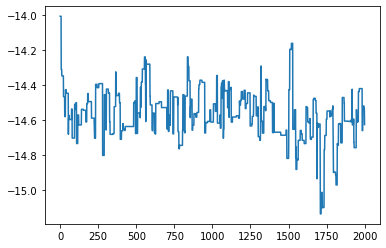

In [30]:
ii = pta.param_names.index("gw_log10_A")

plt.plot(sampler._chain[burn:, ii])

# Things to work on during the hack time

You don't need to do all of these, and you don't need to do them in order.  Pick one (or more) to try.
MCMC's can take a **long** time to run.  You may want to set up a notebook, then wait to run it overnight.
I recommend using the `MarginalizingTimingModel` in all cases, because it is faster than `TimingModel`.
Spatially correlated common signals (e.g. Hellings Downs GWB) are much slower to evaluate than uncorrelated common signals.  If you plan to run an MCMC at this workshop, I recommend only using uncorrelated common signals.

While the MCMC is running you can open up a new notebook and read in the `$outdir/chain_1.txt` and `$outdir/pars.txt` to check on progress.
The number of samples it will take to have well converged posteriors will depend on the specific model.
Using these settings in `sampler.sample` will run for 100k samples, saving every tenth.
That may be enough...
* `Niter=100_000`
* `burn=20_000`
* `thin=10`
Models with more parameters will require more samples to converge.


## ideas:

* Run an MCMC **noise run** with varying WN for one of the 3 pulsars.  Compare the median WN parameters from your MCMC to those in the noise dictionary, `viper_3psr_noise.json`.  Make sure to use the appropriate noise model for that pulsar.

* Run an MCMC **noise run** with varying WN for J2241 **ommitting the band noise** model.  Compare the median WN parameters from your MCMC to those in the noise dictionary, `viper_3psr_noise.json`.

* Setup a `PTA` object using all three pulsars for an **uncorrelated common red noise** signal instead of Hellings-Downs correlated GWB.  Check how the $\mathbb{B}$ a.k.a. $\varphi$ matrix is stored in this case.  Why is it different than the HD correlated case?  Run an MCMC and plot the 1D marginal posterior for the CRN amplitude.

* Do an **uncorrelated common red noise** analysis with **varying spectral index**.  Make a corner plot for the two CRN parameters.

* Pull recent public data from your favorite PTA and set up a `PTA` object to perform an **analysis of your choice**.  Here are `.pkl` files containing a list of `enterprise` `Pulsar` objects for three recent data releases:
 * [EPTA 6PSR](https://drive.google.com/file/d/1MyZX7ox_8TlRUhgk47NirNYcWfEz5ron/view?usp=sharing)
 * [PPTA DR2](https://drive.google.com/file/d/1at5S_ydfqGV2x0PzF4eCO_BXhQjfamKX/view?usp=sharing)
 * [NANOGrav 12.5y](https://drive.google.com/file/d/1eWNLgPOm7mYKAt3LYY_YIb1i19_n03xD/view?usp=sharing)